In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2
device="cuda:0"
import torch
torch.set_float32_matmul_precision('high')

import datasets
import math
import numpy as np
import torch.nn.functional as F
from torchvision.transforms.v2.functional import pil_to_tensor, to_pil_image
from types import SimpleNamespace
from k_diffusion.models.image_transformer_v2 import (
    ImageTransformerDenoiserModelV2,
    GlobalAttentionSpec,
    NeighborhoodAttentionSpec
)
from collections import namedtuple
from fastprogress import master_bar, progress_bar
from timm.optim import Mars

dataset = datasets.load_dataset("danjacobellis/LSDIR_512_f16c12")

env: CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2


Resolving data files:   0%|          | 0/108 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/108 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
config = SimpleNamespace()
config.lr_pow = 2
config.batch_size = 32
config.max_lr = (64/config.batch_size)*1e-3
config.min_lr = config.max_lr / 1e3
config.num_workers = 32
config.epochs = 2
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)

In [3]:
def collate_fn(batch):
    x1 = torch.cat([
        pil_to_tensor(sample['image']).unsqueeze(0)
        for sample in batch
    ]).to(torch.float)/127.5 - 1.0
    x2 = torch.cat([
        pil_to_tensor(sample['conditioning_image']).unsqueeze(0)
        for sample in batch
    ]).to(torch.float)/127.5 - 1.0
    return x1,x2

In [4]:
LevelSpec = namedtuple('LevelSpec', ['width', 'depth', 'd_ff', 'self_attn', 'dropout'])
MappingSpec = namedtuple('MappingSpec', ['depth', 'width', 'd_ff', 'dropout'])

levels = [
    LevelSpec(width=128, depth=2, d_ff=512, self_attn=NeighborhoodAttentionSpec(d_head=64, kernel_size=7), dropout=0.1),
    LevelSpec(width=256, depth=2, d_ff=1024, self_attn=NeighborhoodAttentionSpec(d_head=64, kernel_size=7), dropout=0.1),
    LevelSpec(width=512, depth=2, d_ff=2048, self_attn=NeighborhoodAttentionSpec(d_head=64, kernel_size=7), dropout=0.1),
    LevelSpec(width=1024, depth=4, d_ff=4096, self_attn=GlobalAttentionSpec(d_head=64), dropout=0.1)
]
mapping = MappingSpec(depth=4, width=512, d_ff=2048, dropout=0.1)

# Initialize the model
model = ImageTransformerDenoiserModelV2(
    levels=levels,
    mapping=mapping,
    in_channels=6,         # 3 channels for noisy image + 3 for lossy reconstruction
    out_channels=3,        # Output is the predicted clean RGB image
    patch_size=(4,4),      # Patch size for tokenization
    num_classes=0,         # No class conditioning
    mapping_cond_dim=0     # No additional mapping conditioning
).to(device)

In [5]:
def get_alpha_sigma(t, eta=0.5, log_snr_min=-15, log_snr_max=15):
    log_snr = -2 * (torch.log(torch.tan(math.pi * t / 2)) + math.log(eta))
    log_snr = torch.clamp(log_snr, log_snr_min, log_snr_max)
    alpha_sq = torch.sigmoid(log_snr)
    sigma_sq = torch.sigmoid(-log_snr)
    return torch.sqrt(alpha_sq), torch.sqrt(sigma_sq)

In [6]:
optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

In [7]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []

global_step = 0
model.train()
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn = collate_fn
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x, x_lossy) in enumerate(pb):
        x = x.to(device)
        x_lossy = x_lossy.to(device)
        batch_size = x.shape[0]
        t = torch.rand(batch_size, device=device) * (1.0 - 1e-3) + 1e-3
        alpha_t, sigma_t = get_alpha_sigma(t)
        epsilon = torch.randn_like(x)
        x_noisy = alpha_t.view(-1, 1, 1, 1) * x + sigma_t.view(-1, 1, 1, 1) * epsilon
        x_input = torch.cat([x_noisy, x_lossy], dim=1)  # [batch, 6, 512, 512]
        x_pred = model(x_input, sigma_t)  # [batch, 3, 512, 512]
        loss = F.mse_loss(x_pred, x)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, LR: {learning_rates[-1]:.2g}")

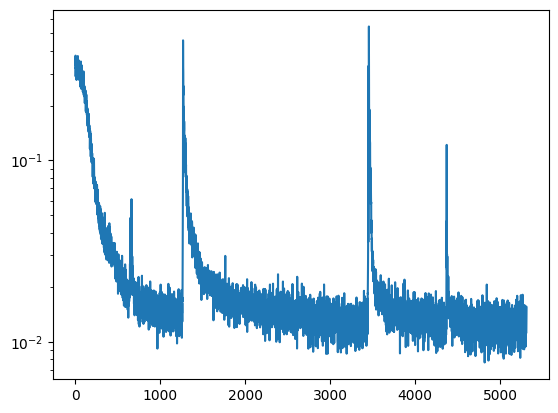

In [10]:
import matplotlib.pyplot as plt
plt.semilogy(losses)

In [13]:
torch.save({
    'state_dict': model.state_dict()
}, '../hf/dance/enhance.pth')

In [70]:
def get_alpha_sigma(t, eta=0.5, log_snr_min=-15, log_snr_max=15):
    # Small epsilon to avoid t = 0 and t = 1
    eps = 1e-6
    t = torch.clamp(t, eps, 1 - eps)
    
    # Compute log_tan
    log_tan = torch.log(torch.tan(math.pi * t / 2))
    
    # Compute log_snr
    log_snr = -2 * (log_tan + math.log(eta))
    log_snr = torch.clamp(log_snr, log_snr_min, log_snr_max)
    
    # Compute alpha and sigma
    alpha_sq = torch.sigmoid(log_snr)
    sigma_sq = torch.sigmoid(-log_snr)
    return torch.sqrt(alpha_sq), torch.sqrt(sigma_sq)

In [72]:
def custom_ddim_sample(model, x_lossy, N=100, device='cuda'):
    """
    Custom DDIM sampler for an x0-predicting model.

    Args:
        model: Trained model that predicts x0
        x_lossy: Lossy reconstruction tensor [1, 3, H, W], range [-1, 1]
        N: Number of denoising steps (default: 100)
        device: Device to run on (default: 'cuda')

    Returns:
        x_enhanced: Enhanced image tensor [1, 3, H, W]
    """
    model.eval()
    with torch.no_grad():
        # Check inputs
        if not torch.isfinite(x_lossy).all():
            raise ValueError("x_lossy contains NaN or Inf values")

        # Define time steps from 1 to 0
        t = torch.linspace(1, 0, N + 1).to(device)  # [1, ..., 0]
        alpha, sigma = get_alpha_sigma(t)  # Your existing function
        alpha_bar = alpha ** 2  # alpha_bar_t = alpha_t^2

        # Verify noise schedule
        if not (torch.isfinite(alpha).all() and torch.isfinite(sigma).all()):
            raise ValueError("alpha or sigma contains NaN/Inf")

        # Initial noise
        x = torch.randn_like(x_lossy)
        print(f"Step 0 - Initial x finite: {torch.isfinite(x).all()}")

        for i in range(N):
            t_curr = t[i]
            t_next = t[i + 1]
            alpha_bar_curr = alpha_bar[i]
            alpha_bar_next = alpha_bar[i + 1]
            sigma_curr = sigma[i]

            # Prepare model input
            x_input = torch.cat([x, x_lossy], dim=1)
            if not torch.isfinite(x_input).all():
                print(f"Step {i} - x_input has NaN/Inf")
                break

            # Model prediction
            x0_pred = model(x_input, sigma_curr).clamp(-1, 1)
            if not torch.isfinite(x0_pred).all():
                print(f"Step {i} - x0_pred has NaN/Inf")
                break

            # Compute epsilon_pred with stability
            denom = torch.sqrt(1 - alpha_bar_curr) + 1e-8  # Prevent division by zero
            epsilon_pred = (x - torch.sqrt(alpha_bar_curr) * x0_pred) / denom
            if not torch.isfinite(epsilon_pred).all():
                print(f"Step {i} - epsilon_pred has NaN/Inf")
                print(f"  x min/max: {x.min().item():.4f}/{x.max().item():.4f}")
                print(f"  x0_pred min/max: {x0_pred.min().item():.4f}/{x0_pred.max().item():.4f}")
                print(f"  denom min: {denom.min().item():.4f}")
                break

            # DDIM update
            x_new = torch.sqrt(alpha_bar_next) * x0_pred + torch.sqrt(1 - alpha_bar_next) * epsilon_pred
            if not torch.isfinite(x_new).all():
                print(f"Step {i} - x_new has NaN/Inf after update")
                print(f"  epsilon_pred min/max: {epsilon_pred.min().item():.4f}/{epsilon_pred.max().item():.4f}")
                break

            x = x_new.clamp(-1, 1)  # Clamp to prevent extreme values

            # Optional: Periodic logging
            if i % 10 == 0:
                print(f"Step {i} - x min/max: {x.min().item():.4f}/{x.max().item():.4f}")

        return x

Step 0 - Initial x finite: True
Step 0 - x min/max: -1.0000/1.0000
Step 10 - x min/max: -1.0000/1.0000
Step 20 - x min/max: -1.0000/0.9977
Step 30 - x min/max: -0.9935/0.9446
Step 40 - x min/max: -0.9527/0.8627


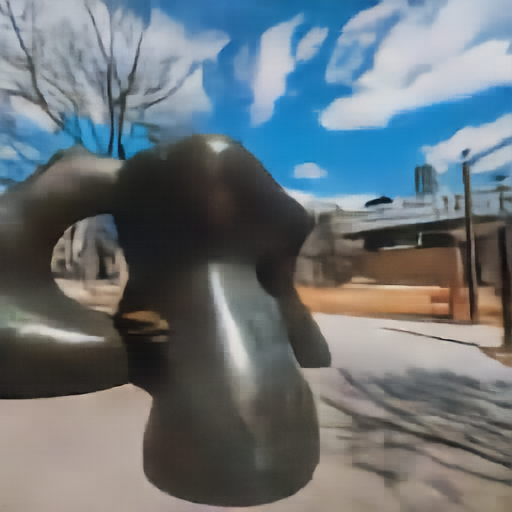

In [75]:
sample = dataset['train'][0]
x = pil_to_tensor(sample['image']).unsqueeze(0).to(device).to(torch.float) / 127.5 - 1.0
x_lossy = pil_to_tensor(sample['conditioning_image']).unsqueeze(0).to(device).to(torch.float) / 127.5 - 1.0

try:
    x_enhanced = custom_ddim_sample(model, x_lossy, N=50)  # Try fewer steps first
    display(to_pil_image(x_enhanced[0].clamp(-1, 1)/2 + 0.5))
except Exception as e:
    print(f"Sampling failed: {e}")